# Project 2 - Network Analysis: 2-Mode Networks
###### Stefano Biguzzi, Dennis Pong, Ian Costello

## Assignment Description

For your second project, you are asked to:

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

## Assignment Steps

### Loading Libraries
Import the libraries necessary for this assignment: `networkx` as "nx", We also import `pandas`, and `matplotlib`.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from networkx.algorithms import bipartite
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

os.chdir(r'C:/Users/biguz/Desktop/CUNY Data Science/Summer2021/DATA 620/Assignments/Project 2')
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data

The data for this project came from Kaggle.com and is based on [meetup.com](https://www.kaggle.com/stkbailey/nashville-meetup?select=meta-members.csv) data for Nashville meetup groups and members. meetup.com is a website for people organizing and attending regular or semi-regular events ("meet-ups"). The relationships amongst users—who goes to what meetups—are a social network, making it ideal for this project.

For this project we are using:
1. `member-to-group-edges.csv`: Edge list for constructing a member-to-group bipartite graph. Weights represent number of events attended in each group.
2. `meta-groups.csv`: Information for each group, including name and category. group_id can serve as index.
3. `meta-members.csv`: Information for each member, including name and location. member_id can serve as index.

In `edge_df`, the member_id is the id of the particular member, the group_id is the id of the group that the member is a aprticipant in, and the weight is the number of times the member went to a meetup for that group.

In [2]:
edge_url = 'https://raw.githubusercontent.com/sbiguzzi/data620/main/Assignments/Project2/member-to-group-edges.csv'
edge_df = pd.read_csv(edge_url)
edge_df.head()

,member_id,group_id,weight
0,2069,19277993,3
1,625050,19277993,2
2,1939496,19277993,1
3,2606806,19277993,4
4,3438546,19277993,1


In `meta_group` dataframe there is additional information for the group_ids. Added type columns for ...

In [3]:
group_url = 'https://raw.githubusercontent.com/sbiguzzi/data620/main/Assignments/Project2/meta-groups.csv'
meta_group = pd.read_csv(group_url)
meta_group['type'] = 'group'
meta_group.head()

,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,type
0,339011,Nashville Hiking Meetup,15838,23,Outdoors & Adventure,4353803,nashville-hiking,group
1,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance,group
2,6335372,Nashville soccer,2869,32,Sports & Recreation,108448302,Nashville-soccer,group
3,10016242,NashJS,1975,34,Tech,8111102,nashjs,group
4,21174496,20's & 30's Women looking for girlfriends,2782,31,Socializing,184580248,new-friends-in-Nashville,group


In `meta_member` dataframe there is additional datapoints for each member.

In [4]:
member_url = 'https://raw.githubusercontent.com/sbiguzzi/data620/main/Assignments/Project2/meta-members.csv'
meta_member = pd.read_csv(member_url)
meta_member['type'] = 'member'

We discovered that some of the group_names from the meta_group dataframe showed up in the meta_member dataframe

In [5]:
meta_member[['member_id','name']].merge(meta_group.rename(columns={'group_name':'name'})['name'],on='name',how='inner')

,member_id,name
0,183427754,NashBI
1,189205349,Nashville Holistic Association
2,193696306,Blues Dance Nashville
3,211399294,GEEK by AKEIN Engineering
4,217856528,Girl Guitar
5,223018602,Her Heart Project
6,225611636,Nashville Flight Training


We had to rename one member from RI$$E to RISSE because the characters broke the code later on in the notebook. Additionally we had to clean the few group_names that also fell into the `meta_member` dataframe from above.

In [6]:
meta_member_clean = meta_member.replace('RI$$E','RISSE')
meta_member_clean = meta_member_clean[~meta_member_clean['name'].isin(list(meta_group.group_name))].reset_index(drop=True)
meta_member_clean.head()

,member_id,name,hometown,city,state,lat,lon,type
0,2069,Wesley Duffee-Braun,Brentwood,Brentwood,TN,36.00,-86.79,member
1,8386,Tim,Nashville,Nashville,TN,36.07,-86.78,member
2,9205,Brenda,Brentwood,Brentwood,TN,36.00,-86.79,member
3,17903,Steve,NaN,Nashville,TN,36.13,-86.80,member
4,20418,Andrea Reynolds,"Huntington, WV",Nashville,TN,36.17,-86.72,member


We then remade the `edges_df` as `edges_clean_df`, where we removed the member_id for the members that were actually groups.

In [7]:
edge_df_clean = edge_df[edge_df['member_id'].isin(list(meta_member_clean['member_id']))].reset_index(drop=True)
edge_df_clean.head()

,member_id,group_id,weight
0,2069,19277993,3
1,625050,19277993,2
2,1939496,19277993,1
3,2606806,19277993,4
4,3438546,19277993,1


### Explore the network

First we initiate the original graph using `nx.from_pandas_dataframe()`. The graph has 25186 nodes and 45534 edges, with the average degree per node of 3.6. This is a large 2-mode dataset and which is ideal for using the Island Method to make it more insightful.

In [8]:
nash = nx.from_pandas_dataframe(edge_df_clean,'member_id','group_id',edge_attr = 'weight')
print(nx.info(nash))

Name: 
Type: Graph
Number of nodes: 25186
Number of edges: 45534
Average degree:   3.6158


We create a list of the connected components subgraphs which is the _component of an undirected graph is an induced subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the rest of the graph_, i.e. the number of independent networks within the larger network. This network has 25 subgraphs, meaning that there are 25 seperate networks within the larger network, that have no edges between them.

In [9]:
len(list(nx.connected_component_subgraphs(nash)))

25

In the histogram below we see that the length of 24 of the 25 subgraphs are just isolated vertecies within the network and then only 1 subgraph is a network of 25124 nodes.

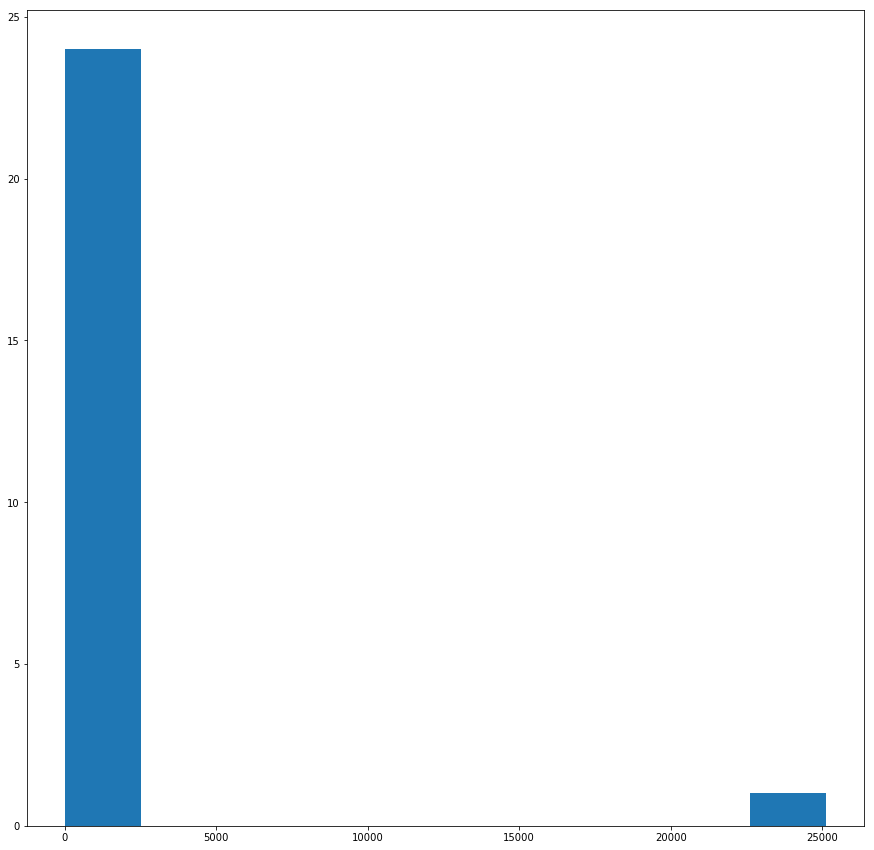

In [10]:
plt.figure(figsize=(15,15))
x=[len(c) for c in list(nx.connected_component_subgraphs(nash))]
_ = plt.hist(x)

We can discard 24 of the subgraphs and only focus on the 1 subgraph that has the highest nodes. That is because the other 24 subgraphs have no more than 7 nodes, making them pretty useless in the analysis.

In [11]:
pd.DataFrame(data=list(zip(list(nx.connected_component_subgraphs(nash)),
                           [len(c) for c in list(nx.connected_component_subgraphs(nash))])),
             columns=['graph','nodes']).sort_values('nodes',ascending=False).reset_index(drop=True)

,graph,nodes
0,"(209321984, 209977357, 184680462, 97910802, 47...",25124
1,"(224769829, 216086789, 224771211, 224772333, 2...",7
2,"(213053412, 213270822, 211050959, 213376758, 1...",6
3,"(234016711, 25428115, 231218711, 233616792, 56...",5
4,"(236334042, 234762500, 25608397)",3
5,"(186312393, 195370860, 18767335)",3
6,"(197475969, 19256403)",2
7,"(234724627, 25604533)",2
8,"(233389780, 25988957)",2
9,"(228221722, 23972116)",2


### Island Method

We will be using the island network described in _Social Network Analysis For Startups - Finding Connections On The Social Web_ by Maksim Tsvetovat and Alexander Kouznetsov to reduce the size of the network to the most influencial members/groups.

The first step in the island method is to create a threshold for which edges to let through and which edges to remove. As described in the book "The function below takes a graph, and applies a threshold (“water level”), letting all edges above a certain value through, and removing all others." The function do as follows:
1. `trim_edges`: creates a new graph were the weights of the original graph's edges is greater than the weight parameter.
2. `island_method`: sets different evenly distriputed weights and runs the trim_edges functions for each of those weights and returns the new graph.

In [12]:
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

In [13]:
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

We take the first element of the connected components subgraph list, which is the graph with 25124 nodes and we run it through the `island_method` function. We print the results and see that if we remove the edges with weight 1, i.e. edges that represent only one event attended by that member to the group, we can remove 11996 nodes and 51 islands.

In [14]:
cc=list(nx.connected_component_subgraphs(nash))[0]
islands=island_method(cc)
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print(i[0],len(i[1]),len(list(nx.connected_component_subgraphs(i[1]))))

1 11996 51
40 310 88
79 126 50
118 46 22
157 17 8
196 8 4


Since members that only go once to a meetup event are not very intersting for analysis, as they may be people who went for a trial and then decided not to go again it makes sense to trim those nodes by using the `trim_edges` function with the weight parameter set to 40.

In [15]:
nash_trimmed = trim_edges(nash,weight=40)
print(nx.info(nash_trimmed))

Name: 
Type: Graph
Number of nodes: 310
Number of edges: 227
Average degree:   1.4645


We now have a network of 310 nodes and 227 edges. This is a much more managebable network and it's composed of more interesting edge pairs, given that the minimum amount of times a member went to a meetup in this network is 40. We can now set up the graph to view all the islands and tnodes that are connected. Below we set up the dataframe so we can label the graph with names rather than IDs. We also set the colors to distinguish between members (cornflowerblue) and groups (orchid), we also set wegiths for the edges width. Finally, we show the graph with `nx.draw_networkx()`.

In [16]:
nash_t_names = pd.Series(meta_member['name'][meta_member['member_id'].isin(nash_trimmed.nodes())].values,index=meta_member['member_id'][meta_member['member_id'].isin(nash_trimmed.nodes())]).to_dict()
group_t_names = pd.Series(meta_group['group_name'][meta_group['group_id'].isin(nash_trimmed.nodes())].values,index=meta_group['group_id'][meta_group['group_id'].isin(nash_trimmed.nodes())]).to_dict()
nash_t_names.update(group_t_names)
nash_trim_labeled = nx.relabel_nodes(nash_trimmed,nash_t_names,copy=True)

In [17]:
nash_t_labels = pd.Series(meta_member['type'][meta_member['name'].isin(nash_trim_labeled.nodes())].values,index=meta_member['name'][meta_member['name'].isin(nash_trim_labeled.nodes())]).to_dict()
group_t_label = pd.Series(meta_group['type'][meta_group['group_name'].isin(nash_trim_labeled.nodes())].values,index=meta_group['group_name'][meta_group['group_name'].isin(nash_trim_labeled.nodes())]).to_dict()
nash_t_labels.update(group_t_label)
nx.set_node_attributes(nash_trim_labeled,'labels',nash_t_labels)

In [18]:
colors_trim = []
for node, data in nash_trim_labeled.nodes(data=True):
    if data['labels'] == 'member':
        colors_trim.append('cornflowerblue')         
    else:
        colors_trim.append('orchid')

In [19]:
weights_trim=[edata['weight'] for f,t,edata in nash_trim_labeled.edges(data=True)]

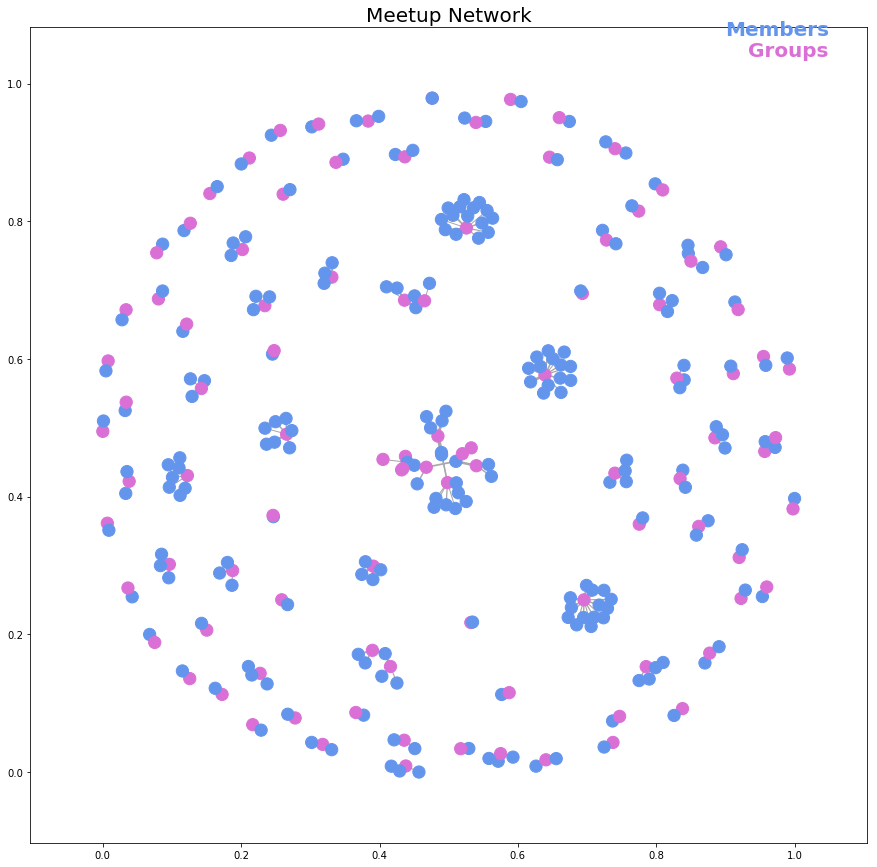

In [20]:
nash_trim_pos = nx.spring_layout(nash_trim_labeled)

plt.figure(figsize=(15,15))
plt.title('Meetup Network',size=20)
nx.draw_networkx(nash_trim_labeled, nash_trim_pos, with_labels=False, node_size=150, node_color=colors_trim, font_size=6,
                 font_family="calibri", width=[x/40 for x in weights_trim], edge_color="darkgray", alpha=1)
_ = plt.text(0.9,1.07,'Members',color='cornflowerblue',fontweight='extra bold',fontsize=20)
_ = plt.text(0.933,1.04,'Groups',color='orchid',fontweight='extra bold',fontsize=20)

In the above graph there are 88 islands, a total of 310 nodes with 227 edges. Interestingly what we see is that there is only one island that has a network of people that share a group most of the other members tend to stick to one meetup group and don't interact between groups.

### Bipartite Graphs

We then set up bipartate graphs from the trimmed data to see how the meetup groups create networks between members. We use the `bipartite.weighted_projected_graph()` to create the member graph and then set it up so the labels are the names of members and not the IDs. Finally, we draw the graph again using `nx.draw_netowrkx()`.

In [21]:
M = bipartite.projected_graph(nash_trimmed,edge_df['member_id'][edge_df['member_id'].isin(nash_trimmed.nodes())])

In [22]:
M_names = pd.Series(meta_member['name'][meta_member['member_id'].isin(M.nodes())].values,index=meta_member['member_id'][meta_member['member_id'].isin(M.nodes())]).to_dict()
M_labeled = nx.relabel_nodes(M,M_names,copy=True)

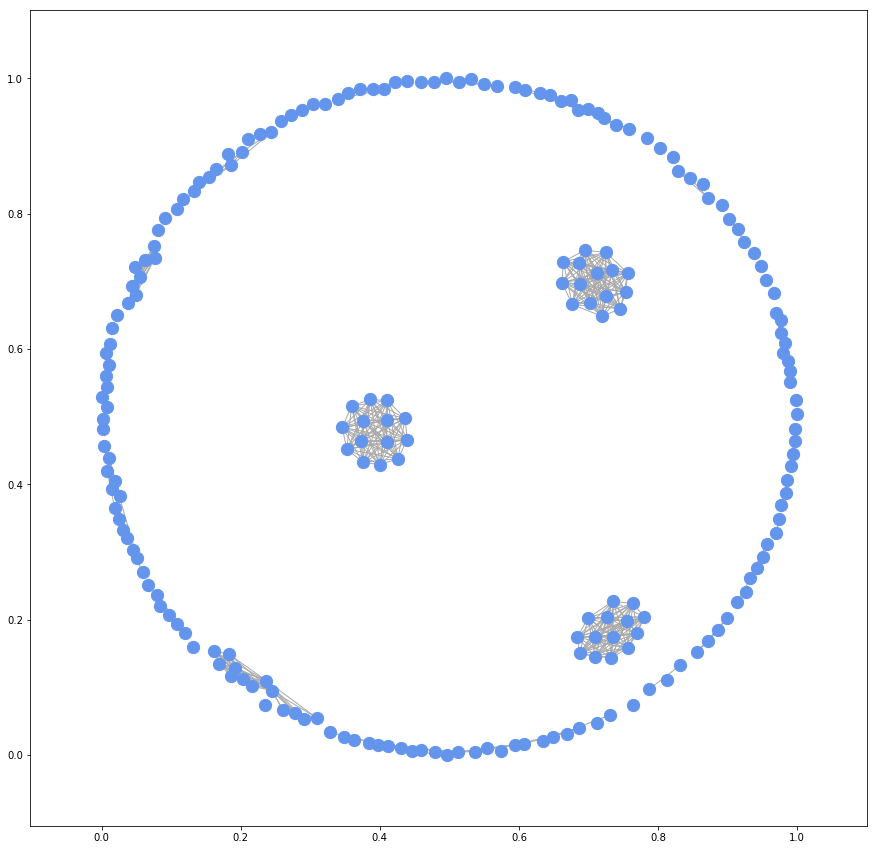

In [23]:
plt.figure(figsize=(15,15))
nx.draw_networkx(M_labeled,with_labels=False,node_size=150,font_size=10,
                 node_color='cornflowerblue',edge_color="darkgray", alpha=1)

The graph above shows a lot of subgraphs within the larger member bipartate graph. Most of them look to be single or double networks as we see in the histogram below. We also list the number of nodes in each graph in the dataframe below.

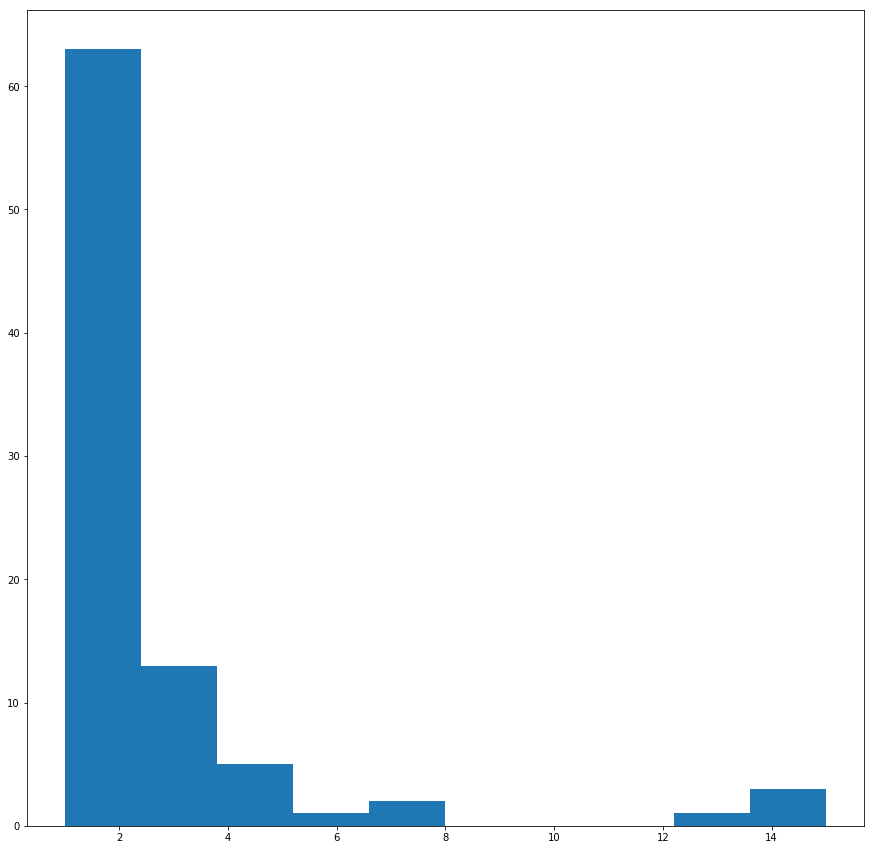

In [24]:
plt.figure(figsize=(15,15))
M_sub=[len(c) for c in list(nx.connected_component_subgraphs(M_labeled))]
_ = plt.hist(M_sub)

In [25]:
pd.DataFrame(data=list(zip(list(nx.connected_component_subgraphs(M_labeled)),
                           [len(c) for c in list(nx.connected_component_subgraphs(M_labeled))])),
             columns=['graph','nodes']).sort_values('nodes',ascending=False).reset_index(drop=True).head(n=25)

,graph,nodes
0,"(Ali Ait Taleb, Jonny Herberich, Keaton Wald, ...",15
1,"(Don Cee, Jen, Michael Smulin, Kristina Thornt...",14
2,"(Brynda, Julia Saner, Ray Dennison, Jeannie, B...",14
3,"(Glenn W., Bob, Toni, Tammy Hutchinson, Linda ...",13
4,"(Colin Yearwood, Jake Lewis, LaShandra Oliver-...",7
5,"(Ben Jordan, Joe Thayer, Clif, Hugh Daniel, Gr...",7
6,"(Tim Jones, Robin Barnes, Joyce Dierschke, Bec...",6
7,"(Maurice Painter, NEIL SMITH, Tim Cummings, Ke...",5
8,"(Steve Daniel, Laura K., jerry hendrixson, Sus...",5
9,"(Jody Dobrin, Kathryn, Mirabelle Stoedter, Den...",4


Analyzing a network with less than 10 nodes is not very intersting so the `node_trim` function takes only edges where the degree is > a certain node_count. In our example we only take the graphs with more than 10 nodes, the top 4 graphs, and visualize them below.

In [26]:
def node_trim(g,node_count=1):
    list_n = []
    for k,v in g.degree().items():
        if v > node_count:
            list_n.append(k)
    g2 = nx.Graph()
    for f,to in g.edges(list_n):
        g2.add_edge(f,to)
    return g2

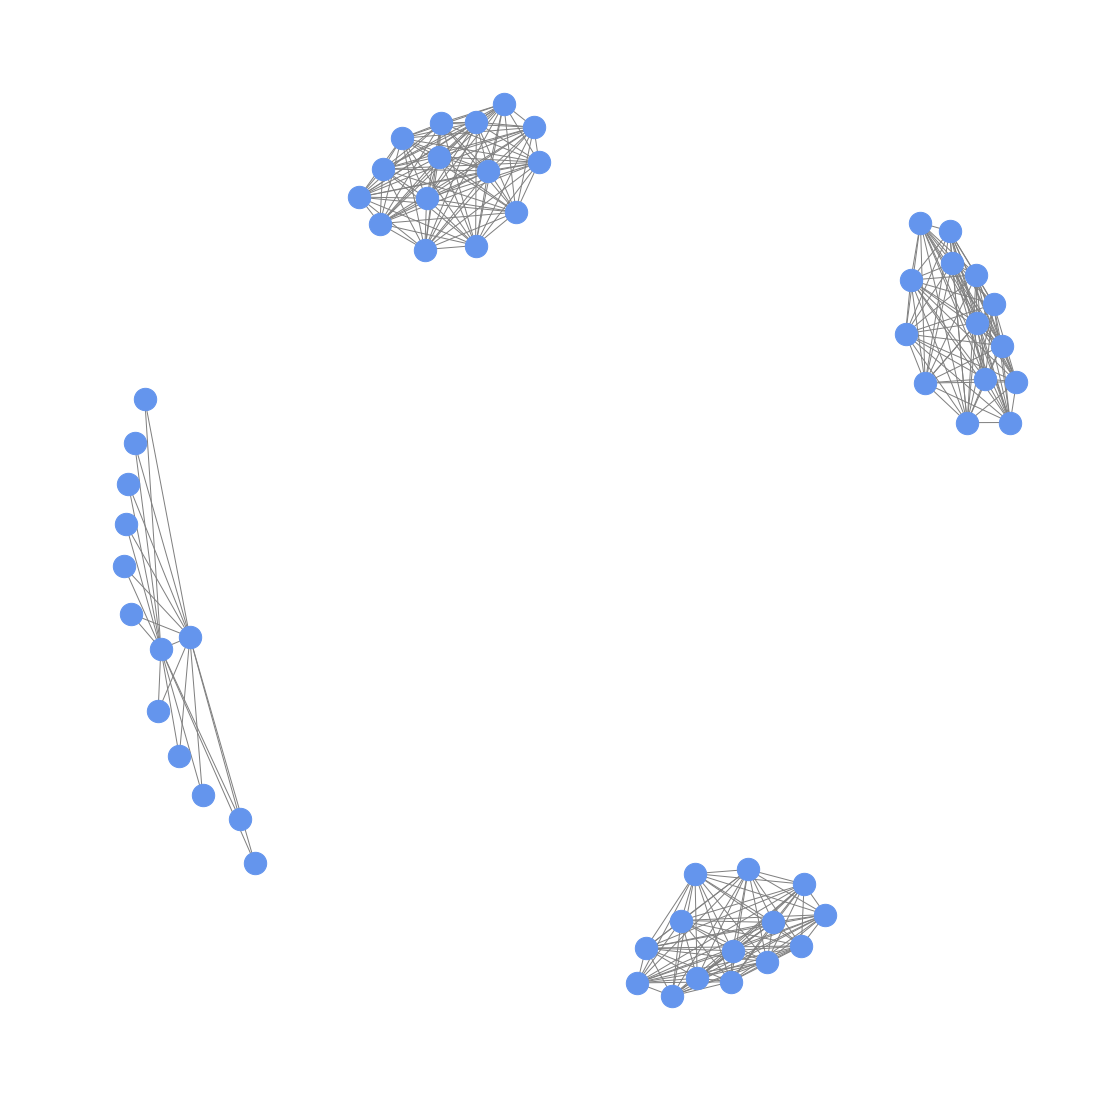

In [27]:
M2 = node_trim(M,node_count=10)
plt.figure(figsize=(15,15))
M2_pos = nx.spring_layout(M2)
nx.draw(M2,M2_pos,with_labels=False,node_color='cornflowerblue',node_size=500,edge_color='grey')

We can see that in three out of the four subgraphs everyone has a connection to everyone, that is everyones centrality measures are the same. In one of the graphs however, we can see that two members connect the group, making it a more intersting network to explore. We create `M_map` with the correct subgraph, which happens to be the one with 13 nodes, and we calculate all the centrality measures for the nodes in the graph. Set them in a dataframe and sort the dataframe by the eigenvector centrality column.

In [28]:
M_map = [c for c in list(nx.connected_component_subgraphs(M)) if len(c)==13][0]

In [29]:
cent_df = pd.DataFrame(nx.degree_centrality(M_map).items(),columns=['member_id','degree'])
cent_df['eigenvector'] = nx.eigenvector_centrality(M_map).values()
cent_df['betweenness'] = nx.betweenness_centrality(M_map).values()
cent_df['closeness'] = nx.closeness_centrality(M_map).values()
cent_df.sort_values('eigenvector',ascending=False)

,member_id,degree,eigenvector,betweenness,closeness
6,198309808,1.000000,0.364946,0.212121,1.000000
8,191512916,1.000000,0.364946,0.212121,1.000000
9,9702068,0.666667,0.307043,0.000000,0.750000
10,159654132,0.666667,0.307043,0.000000,0.750000
12,190147610,0.666667,0.307043,0.000000,0.750000
1,71424452,0.666667,0.307043,0.000000,0.750000
2,150907332,0.666667,0.307043,0.000000,0.750000
4,200790668,0.666667,0.307043,0.000000,0.750000
5,118484462,0.666667,0.307043,0.000000,0.750000
0,128991232,0.416667,0.135740,0.000000,0.631579


We see that members 198309808 and 191512916 are the most influential members of this subnetwork. This could indicate that these two members are the organizers of the groups they are participating in. We can check this by looking at the groups they are in and seeing the if their member_ids match the organizer_id.

In [30]:
inf_df = edge_df[['member_id','group_id']][edge_df['member_id'].isin(cent_df['member_id'][cent_df['degree']==1])]
inf_df = inf_df.merge(meta_group[['group_id','organizer_id']],on=['group_id'],how='left')
inf_df[inf_df['member_id']==inf_df['organizer_id']]

,member_id,group_id,organizer_id
9,198309808,18243826,198309808


It looks like member 198309808 is an organizer for one of the groups, which could explain why they have more influence over the subgraph than the other members. Another option to explore is looking at where on a map these members live. Using the latitude and longitude columns (which we believe are related to the zipcode in which the members live) we can map out the location of all the members in this subnetwork. We start my creating `mem_map` which holds the member information for the members in the subnetwork.

In [31]:
mem_map = meta_member[meta_member['member_id'].isin(M_map.nodes())]
mem_map.head()

,member_id,name,hometown,city,state,lat,lon,type
1491,9702068,Toni,"Murfreesboro, TN",Murfreesboro,TN,35.82,-86.45,member
3808,37118292,Bob,NaN,Gallatin,TN,36.39,-86.45,member
5013,71424452,Barbara L.,NaN,Nashville,TN,36.17,-86.78,member
5960,98198412,Tammy Hutchinson,NaN,Hendersonville,TN,36.32,-86.61,member
6721,118484462,Lana Barabash,Nashville,Nashville,TN,36.06,-86.96,member


To replicate the next part of the notebook, you will have to download the [shapefile](https://github.com/sbiguzzi/data620/blob/main/Assignments/Project2/tl_2018_47037_roads.shp) and the [shx](https://github.com/sbiguzzi/data620/blob/main/Assignments/Project2/tl_2018_47037_roads.shx) and save them into your working directory. We then use the `gpd.read_file()` function to load in the shapefile and set some parameters for the geodfataframe. We then show the map graph with each point representing a member location.

In [32]:
streetmap = gpd.read_file('tl_2018_47037_roads.shp')

crs = {'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(mem_map['lon'],mem_map['lat'])]

geo_df = gpd.GeoDataFrame(mem_map,crs=crs,geometry=geometry)
geo_df

,member_id,name,hometown,city,state,lat,lon,type,geometry
1491,9702068,Toni,"Murfreesboro, TN",Murfreesboro,TN,35.82,-86.45,member,POINT (-86.45000 35.82000)
3808,37118292,Bob,NaN,Gallatin,TN,36.39,-86.45,member,POINT (-86.45000 36.39000)
5013,71424452,Barbara L.,NaN,Nashville,TN,36.17,-86.78,member,POINT (-86.78000 36.17000)
5960,98198412,Tammy Hutchinson,NaN,Hendersonville,TN,36.32,-86.61,member,POINT (-86.61000 36.32000)
6721,118484462,Lana Barabash,Nashville,Nashville,TN,36.06,-86.96,member,POINT (-86.96000 36.06000)
7109,128991232,Linda Carney,Goodlettsville,Goodlettsville,TN,36.33,-86.74,member,POINT (-86.74000 36.33000)
7910,150907332,Larry Adcock,McMinnville,Smyrna,TN,35.97,-86.51,member,POINT (-86.51000 35.97000)
8292,159654132,Ted Chessor,NaN,Nashville,TN,36.09,-86.75,member,POINT (-86.75000 36.09000)
10677,188527897,Glenn W.,NaN,Hendersonville,TN,36.32,-86.61,member,POINT (-86.61000 36.32000)
11075,190147610,Monica V,"Antioch, TN",Antioch,TN,36.04,-86.64,member,POINT (-86.64000 36.04000)


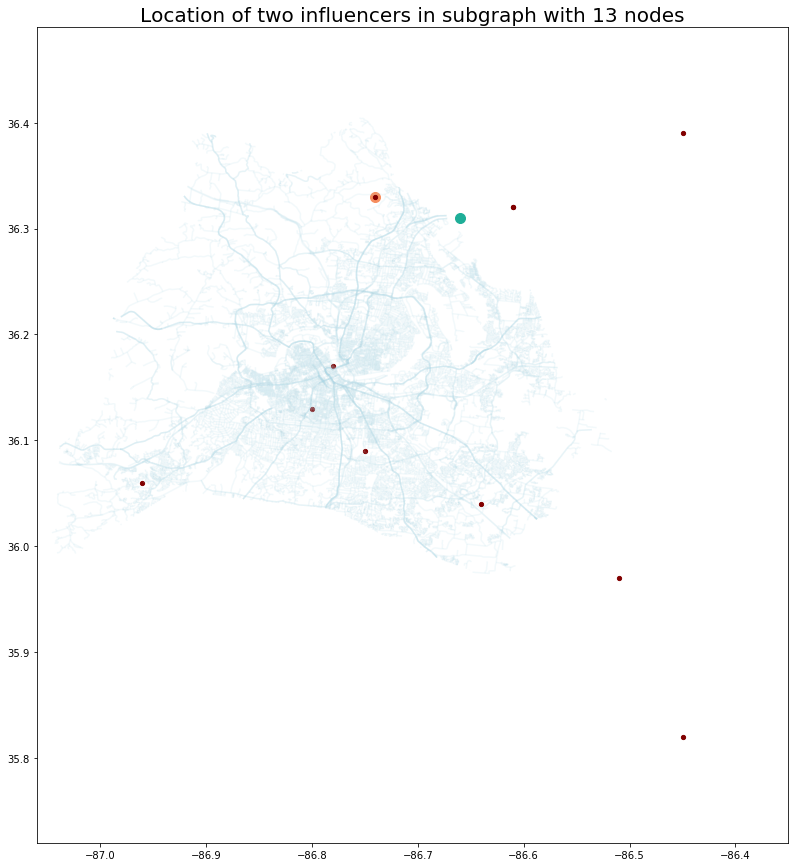

In [33]:
fig,ax=plt.subplots(figsize=(15,15))
streetmap.plot(ax=ax,alpha=0.15,color='lightblue')

geo_df[geo_df['member_id']==198309808].plot(ax=ax,markersize=100,color='#F68E5F',marker='o')
geo_df[geo_df['member_id']==191512916].plot(ax=ax,markersize=100,color='#1EAE98',marker='o')
geo_df[~(geo_df['member_id'].isin([198309808,191512916]))].plot(ax=ax,markersize=18,color='#810000',marker='o')

_ = ax.set_xlim(min(geo_df.lon)-0.1, max(geo_df.lon)+0.1)
_ = ax.set_ylim(min(geo_df.lat)-0.1, max(geo_df.lat)+0.1)
_ = plt.title("Location of two influencers in subgraph with 13 nodes",fontsize=20)

We found it intersting that the people with the most influence did not live towards the center of the map, which would make more logical sense. This might be due to the fact that because one of the members is the organizer (the orange dot), they may arrange the group's meetup around that zipcode, which is on the outskirts of Davidson County, the county that Nashville is in. The other influential member also lives on the outskirts of Davidson County (the blue dot), but close by to the organizer. It is possible that the two know each other outside of the meetup.com website, could be friends or dating, and that is why they are members in the same groups and hold the same influential power in this network. It would be intersting to figure out the relationship between the two, but there is not much more in the data that can tell us this.

### Subgraphs—Ego Networks

Another thing we wanted to look at was the amount of people you could connect with by just being a participant in a meetup group. To do this we can create an Ego Networks for one of the members. In our example we wanted to choose a member who did not participate in too many groups as that would make our ego network graph unreadable. First we took the members that were in the M2 network from the above section and we counted the number of meetup groups they were in. Finally we took a random member_id for a member that participates in 3 groups and assigned it to member_id variable.

In [34]:
group_counts = edge_df[edge_df['member_id'].isin(M2.nodes())].groupby(['member_id'])['group_id'].nunique().reset_index()
group_counts = group_counts.sort_values('group_id',ascending=False).merge(meta_member[['member_id','name']],
                                                                         on='member_id',how='left')
member_id = int(group_counts['member_id'][group_counts['group_id']==3].sample(random_state=4321))

We initiated the ego_graph with a radius of one. This would give us all the groups the random member was connected to. We relabled some of the nodes and set the color and lables for the network, as well as the weights for the edges.

In [35]:
graph_r1 = nx.ego_graph(G=nash,n=member_id, radius=1)

In [36]:
graph_r1_labels = pd.Series(meta_member['type'][meta_member['member_id'].isin(graph_r1.nodes())].values,index=meta_member['member_id'][meta_member['member_id'].isin(graph_r1.nodes())]).to_dict()
group_label_r1 = pd.Series(meta_group['type'][meta_group['group_id'].isin(graph_r1.nodes())].values,index=meta_group['group_id'][meta_group['group_id'].isin(graph_r1.nodes())]).to_dict()
graph_r1_labels.update(group_label_r1)
nx.set_node_attributes(graph_r1,'labels',graph_r1_labels)

In [37]:
graph_r1_names = pd.Series(meta_member['name'][meta_member['member_id'].isin(graph_r1.nodes())].values,index=meta_member['member_id'][meta_member['member_id'].isin(graph_r1.nodes())]).to_dict()
group_names_r1 = pd.Series(meta_group['group_name'][meta_group['group_id'].isin(graph_r1.nodes())].values,index=meta_group['group_id'][meta_group['group_id'].isin(graph_r1.nodes())]).to_dict()
graph_r1_names.update(group_names_r1)
graph_r1_labeled = nx.relabel_nodes(graph_r1,graph_r1_names)

In [38]:
colors_r1 = []
for node, data in graph_r1.nodes(data=True):
    if data['labels'] == 'member':
        colors_r1.append('cornflowerblue')         
    else:
        colors_r1.append('orchid')

In [39]:
g_r1_labels = {}
for node, data in graph_r1.nodes(data=True):
    if node == member_id:
        g_r1_labels.update({node:meta_member['name'][meta_member['member_id']==member_id].to_string().split('    ')[1]})
    else:
        if data['labels'] == 'group':
            g_r1_labels.update({node:meta_group['group_name'][meta_group['group_id']==node].to_string().split('    ')[1]})
        else:
            g_r1_labels.update({node:''})

In [40]:
weights_r1=[edata['weight'] for f,t,edata in graph_r1.edges(data=True)]

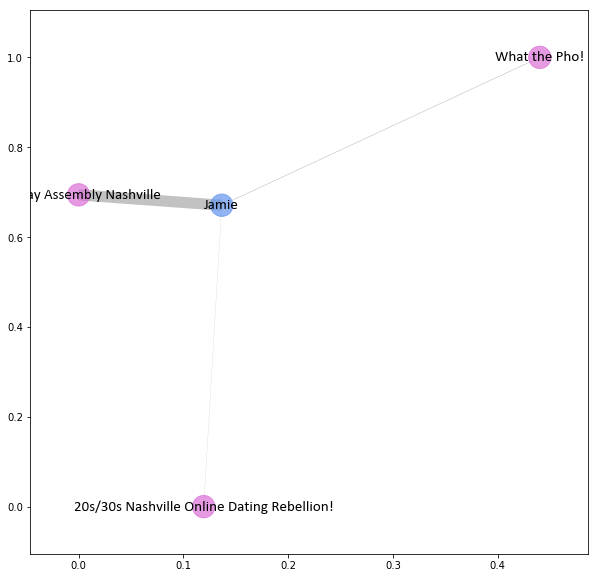

In [41]:
plt.figure(figsize=(10,10))
pos_r1 = nx.spring_layout(graph_r1)
nx.draw_networkx(graph_r1,pos_r1,with_labels=False,node_size=500,node_color=colors_r1,
                 width=[x/5 for x in weights_r1],edge_color="darkgray", alpha=0.7)
__ = nx.draw_networkx_labels(graph_r1,pos_r1,labels=g_r1_labels,font_size=15,font_family='calibri')

In the graph above we can see that Jamie has a connection to three groups. Jamie attends the Sunday Assembly Nashville group the most, 56 times, presumably because Jamie goes every sunday. The other groups Jamie attended less than 5 times, whcich is not a lot but there is a potential for them to navigate that group in the future.

If we want to see how many people Jamie has access to from his 3 meetup groups, we can extend the radius of the graph to 2. This will make a connection between Jamie and all other members of the three groups Jamie attended. We first instantiate the graph, changing the radius to 2. We then relabel and rename the nodes in the graph, set the color and weights. Set it so the labels only show for Jamie and the group, and finally show the graph.

In [42]:
graph_r2 = nx.ego_graph(G=nash,n=member_id, radius=2)

In [43]:
graph_r2_labels = pd.Series(meta_member['type'][meta_member['member_id'].isin(graph_r2.nodes())].values,index=meta_member['member_id'][meta_member['member_id'].isin(graph_r2.nodes())]).to_dict()
group_label_r2 = pd.Series(meta_group['type'][meta_group['group_id'].isin(graph_r2.nodes())].values,index=meta_group['group_id'][meta_group['group_id'].isin(graph_r2.nodes())]).to_dict()
graph_r2_labels.update(group_label_r2)
nx.set_node_attributes(graph_r2,'labels',graph_r2_labels)

In [44]:
graph_r2_names = pd.Series(meta_member['name'][meta_member['member_id'].isin(graph_r2.nodes())].values,index=meta_member['member_id'][meta_member['member_id'].isin(graph_r2.nodes())]).to_dict()
group_names_r2 = pd.Series(meta_group['group_name'][meta_group['group_id'].isin(graph_r2.nodes())].values,index=meta_group['group_id'][meta_group['group_id'].isin(graph_r2.nodes())]).to_dict()
graph_r2_names.update(group_names_r2)
graph_r2_labeled = nx.relabel_nodes(graph_r2,graph_r2_names)

In [45]:
colors_r2 = []
for node, data in graph_r2.nodes(data=True):
    if node == member_id:
        colors_r2.append('red')
    else:
        if data['labels'] == 'member':
            colors_r2.append('cornflowerblue')         
        else:
            colors_r2.append('orchid')

In [46]:
weights_r2=[edata['weight'] for f,t,edata in graph_r2.edges(data=True)]

In [47]:
g_r2_labels = {}
for node, data in graph_r2.nodes(data=True):
    if node == member_id:
        g_r2_labels.update({node:meta_member['name'][meta_member['member_id']==member_id].to_string().split('    ')[1]})
    else:
        if data['labels'] == 'group':
            g_r2_labels.update({node:meta_group['group_name'][meta_group['group_id']==node].to_string().split('    ')[1]})
        else:
            g_r2_labels.update({node:''})

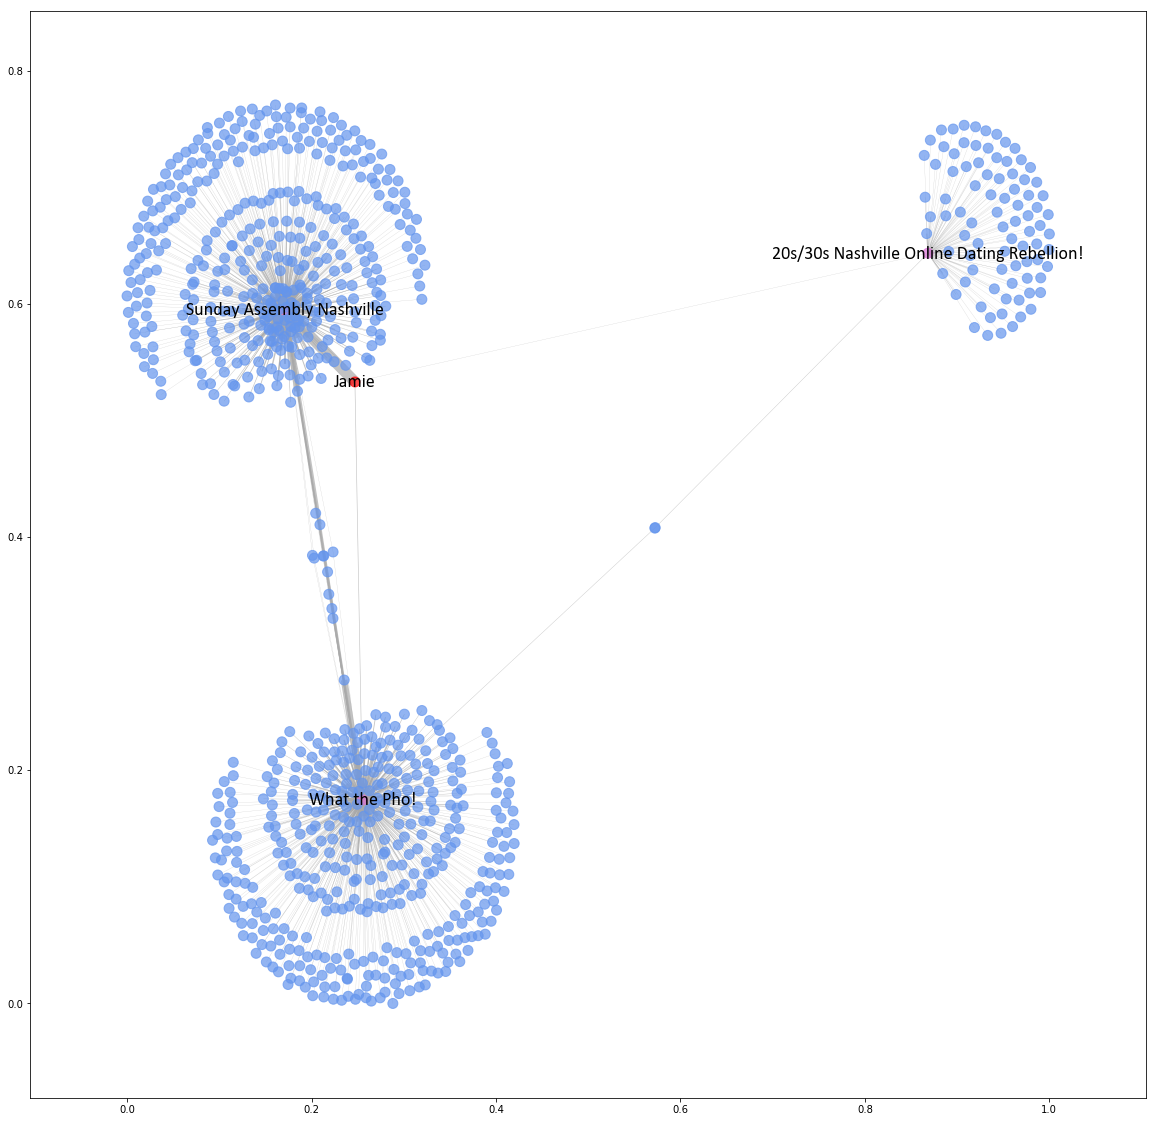

In [48]:
plt.figure(figsize=(20,20))
pos_r2 = nx.spring_layout(graph_r2)
nx.draw_networkx(graph_r2,pos_r2,with_labels=False,node_size=100,node_color=colors_r2,
                 width=[x/5 for x in weights_r2],edge_color="darkgray", alpha=0.7)
___ = nx.draw_networkx_labels(graph_r2,pos_r2,labels=g_r2_labels,font_size=18,font_family='calibri')

In [49]:
g_list = []
for n,d in graph_r2.nodes(data=True):
    if (d['labels'] == 'group'):
        g_list.append(n)
meta_group[['group_name','num_members']][meta_group['group_id'].isin(g_list)]

,group_name,num_members
5,Sunday Assembly Nashville,918
36,What the Pho!,1889
138,20s/30s Nashville Online Dating Rebellion!,1124


We clearly see that Jamie is closely related to the other 917 members of the Sunday Assembly Nasshville, which makes sense given that Jamie attended events for this group 56 times. However, just going to the other two groups just once gives him access to a much larger network. In fact, Jamie is able to connect with 1,888 people from the What the Pho! group and 1,123 people from the 20s/30s Nashville Online Dating Rebellion!. This gives Jamie access to 3,931 people split across three groups.

# YouTube Link